# **Retail Rocket business analysis**

## Preparation steps

In [ ]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
events = pd.read_csv('events.csv')
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


The timestamp format is unsuitable

In [ ]:
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [ ]:
event_types = duckdb.query("""
  SELECT event, COUNT(*) AS event_counts
  FROM events
  GROUP BY event
  ORDER BY event_counts DESC
""").df()

event_types

,event,event_counts
0,view,2664312
1,addtocart,69332
2,transaction,22457


# CASE 1

Transactions

In [ ]:
funnel = event_types.set_index('event')['event_counts']

view_count = funnel['view']
cart_count = funnel['addtocart']
trans_count = funnel['transaction']

view_to_cart = cart_count / view_count
view_to_cart

np.float64(0.02602247784793973)

In [ ]:
cart_to_buy = trans_count / cart_count

cart_to_buy

np.float64(0.3239052674089886)

In [ ]:
view_to_buy = trans_count / view_count
view_to_buy

np.float64(0.008428817645981402)

In [ ]:
df = pd.DataFrame({'Conversion types': ['View -> cart', 'Cart -> transaction', 'View -> transaction'], 'Conversion rate': [view_to_cart, cart_to_buy, view_to_buy]})

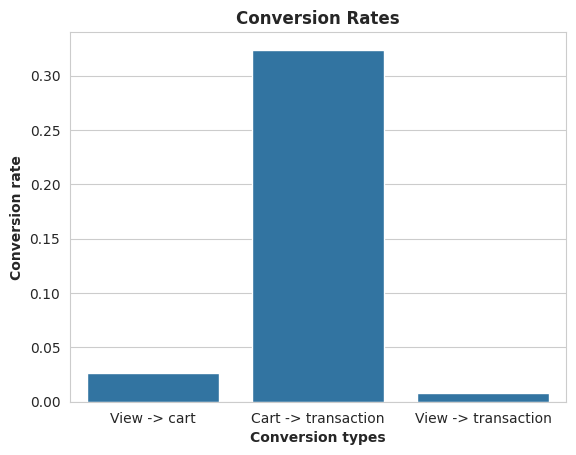

In [ ]:
sns.set_style("whitegrid")
ax = sns.barplot(x = 'Conversion types', y = 'Conversion rate', data=df)
ax.set_title('Conversion Rates', fontweight='bold')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})


plt.show()

## The average ecommerce add-to-cart rate generally falls between 6% and 11% and our rate is significantly lower with 2.6%.

## The average online shopping cart abandonment rate is approximately 70%-75%, and that is almost the same as our data (68%)

## The average e-commerce conversion rate typically ranges between 1% and 4%, and our bussiness is behind in this aspect (0.8%)

##In conclusion, our CR is weak and incurs bussiness lossess

# CASE 2: Retention analysis

In [ ]:
retention = duckdb.query("""
  SELECT visitorid, COUNT(*) AS trans_count
  FROM events
  WHERE event = 'transaction'
  GROUP BY visitorid
""").df()
retention

,visitorid,trans_count
0,121688,11
1,552148,1
2,102019,2
3,945184,1
4,1406787,1
...,...,...
11714,1118015,1
11715,1163417,1
11716,1316429,1
11717,331807,1


In [ ]:
retention_sum = duckdb.query("""
  SELECT
    SUM(CASE WHEN trans_count = 1 THEN 1 ELSE 0 END) AS one_timers_count,
    SUM(CASE WHEN trans_count > 1 THEN 1 ELSE 0 END) AS loyals_count
  FROM retention
""").df()

retention_sum

,one_timers_count,loyals_count
0,9143.0,2576.0


In [ ]:
retention_sum['loyals_count'] / retention['visitorid'].count()

,loyals_count
0,0.219814


## The % of loyal customers (customers, that made more than 1 transaction) is approx. 22%, which can lead to conclusion that our customers are generally satisfied with our product, however, the business has trouble getting new customers to proceed with the transaction after they viewed the product
